In [1]:
import sys
sys.path.append("../")
from plotting import CandlePlot
import pandas as pd

In [2]:
from technicals.patterns import apply_patterns

In [3]:
df = pd.read_pickle("../data/GBP_JPY_H1.pkl")

In [4]:
df_an = df[['time', 'mid_o', 'mid_h', 'mid_l', 'mid_c']].copy()

In [5]:
df_an.tail()

,time,mid_o,mid_h,mid_l,mid_c
37219,2021-12-30 19:00:00+00:00,155.312,155.444,155.274,155.444
37220,2021-12-30 20:00:00+00:00,155.442,155.470,155.289,155.312
37221,2021-12-30 21:00:00+00:00,155.317,155.382,155.286,155.382
37222,2021-12-30 22:00:00+00:00,155.353,155.381,155.282,155.329
37223,2021-12-30 23:00:00+00:00,155.336,155.360,155.284,155.310


In [ ]:
# direction = df_an.mid_c - df_an.mid_o
# body_size = abs(direction)
# direction = [1 if x >= 0 else -1 for x in direction]
# full_range = df_an.mid_h - df_an.mid_l
# body_perc = (body_size / full_range) * 100
# body_lower = df_an[['mid_c','mid_o']].min(axis=1)
# body_upper = df_an[['mid_c','mid_o']].max(axis=1)
# body_bottom_perc = ((body_lower - df_an.mid_l) / full_range) * 100
# body_top_perc = 100 - (((df_an.mid_h - body_upper) / full_range) * 100)

In [ ]:
# df_an['body_lower'] = body_lower
# df_an['body_upper'] = body_upper
# df_an['body_perc'] = body_perc
# df_an['body_bottom_perc'] = body_bottom_perc
# df_an['body_top_perc'] = body_top_perc
# df_an['full_range'] = full_range

In [6]:
df_an = apply_patterns(df_an)

In [19]:
HANGING_MAN_BODY = 15.0
HANGING_MAN_HEIGHT = 75.0
SHOOTING_STAR_HEIGHT = 25.0
SPINNING_TOP_MIN = 40.0
SPINNING_TOP_MAX = 60.0
MARUBOZU = 98.0
ENGULFING_FACTOR = 1.1

apply_marubozu = lambda x: x.body_perc > MARUBOZU

def apply_hanging_man(row):
    if row.body_bottom_perc > HANGING_MAN_HEIGHT:
        if row.body_perc < HANGING_MAN_BODY:
            return True
    return False

def apply_shooting_star(row):
    if row.body_top_perc < SHOOTING_STAR_HEIGHT:
        if row.body_perc < HANGING_MAN_BODY:
            return True
    return False

def apply_spinning_top(row):
    if row.body_top_perc < SPINNING_TOP_MAX:
        if row.body_bottom_perc > SPINNING_TOP_MIN:
            if row.body_perc < HANGING_MAN_BODY:
                return True
    return False

def apply_engulfing(row):
    if row.direction != row.direction_prev:
        if row.body_size > row.body_size_prev * ENGULFING_FACTOR:
            return True
    return False

TWEEZER_BODY = 15.0
TWEEZER_HL = 0.01
TWEEZER_TOP_BODY = 40.0
TWEEZER_BOTTOM_BODY = 60.0

def apply_tweezer_top(row):
    if abs(row.body_size_change) < TWEEZER_BODY:
        if row.direction == -1 and row.direction != row.direction_prev:
            if abs(row.low_change) < TWEEZER_HL and abs(row.high_change) < TWEEZER_HL:
                if row.body_top_perc < TWEEZER_TOP_BODY:
                    return True
    return False

def apply_tweezer_bottom(row):
    if abs(row.body_size_change) < TWEEZER_BODY:
        if row.direction == 1 and row.direction != row.direction_prev:
            if abs(row.low_change) < TWEEZER_HL and abs(row.high_change) < TWEEZER_HL:
                if row.body_bottom_perc > TWEEZER_BOTTOM_BODY:
                    return True
    return False

In [20]:
df_an['body_size_prev'] = df_an.body_size.shift(1)
df_an['direction_prev'] = df_an.direction.shift(1)
df_an['HANGING_MAN'] = df_an.apply(apply_hanging_man, axis=1)
df_an['SHOOTING_STAR'] = df_an.apply(apply_shooting_star, axis=1)
df_an['SPINNING_TOP'] = df_an.apply(apply_spinning_top, axis=1)
df_an['MARUBOZU'] = df_an.apply(apply_marubozu, axis=1)
df_an['ENGULFING'] = df_an.apply(apply_engulfing, axis=1)
df_an['TWEEZER_TOP'] = df_an.apply(apply_tweezer_top, axis=1)
df_an['TWEEZER_BOTTOM'] = df_an.apply(apply_tweezer_bottom, axis=1)

In [21]:
df_an[df_an['TWEEZER_BOTTOM'] == True]

,time,mid_o,mid_h,mid_l,mid_c,body_lower,body_upper,body_bottom_perc,body_top_perc,body_perc,...,body_size_change,body_size_prev,direction_prev,HANGING_MAN,SHOOTING_STAR,SPINNING_TOP,MARUBOZU,ENGULFING,TWEEZER_TOP,TWEEZER_BOTTOM
11724,2017-11-23 12:00:00+00:00,148.009,148.074,147.906,148.032,148.009,148.032,61.309524,75.0,13.690476,...,-4.166667,0.024,-1.0,False,False,False,False,False,False,True


In [22]:
import plotly.graph_objects as go

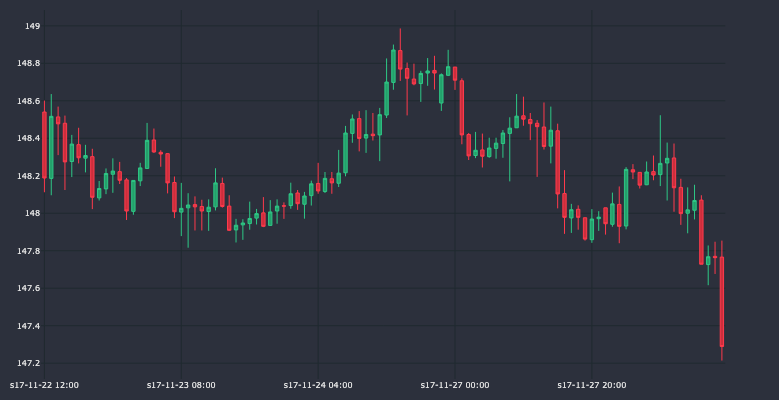

In [23]:
MARKER = '#0066FF'
dfp = df_an.iloc[11700:11800]
cp = CandlePlot(dfp, candles=True)
df_temp = cp.df_plot[cp.df_plot.TWEEZER_TOP==True]
cp.fig.add_trace(go.Candlestick(
                x=df_temp.sTime,
                open=df_temp.mid_o,
                high=df_temp.mid_h,
                low=df_temp.mid_l,
                close=df_temp.mid_c,
                line=dict(width=1), opacity=1,
                increasing_fillcolor=MARKER,
                decreasing_fillcolor=MARKER,
                increasing_line_color=MARKER,  
                decreasing_line_color=MARKER
            ))

cp.show_plot()